The problem statement:
https://gym.openai.com/envs/MsPacman-v0

In [1]:
%load_ext autoreload
%autoreload 2

import gym
#!pip3 install box2d
import random
import torch
from torchvision import transforms

import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from dqn_agent_3d import Agent

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
env = gym.make('MsPacman-v0')
env.seed(0)
state_space = env.observation_space.shape
action_space = env.action_space.n
input_shape = (84,84)
states_stack_depth = 4
print('State shape: ', state_space)
print('Number of actions: ', action_space)

State shape:  (210, 160, 3)
Number of actions:  9


In [3]:
# For inputs basic pre-processing
encode_states = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(input_shape),
    transforms.ToTensor()
    ]
)

In [4]:
#import images
s = env.reset()
encode_states(s).shape

torch.Size([1, 84, 84])

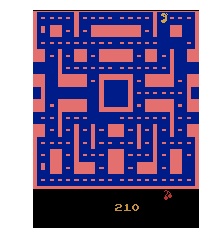

In [8]:
untrained_agent = Agent(state_size=states_stack_depth, action_size=action_space, seed=10)

# watch an untrained agent
states_stack = deque([torch.zeros(input_shape) for z in range(states_stack_depth)], maxlen=states_stack_depth)

state = env.reset()
state_inputs = state2StackedInputs(state, states_stack)

img = plt.imshow(env.render(mode='rgb_array'))
for j in range(1000):
    action = untrained_agent.act(state_inputs)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

In [5]:
agent = Agent(state_size=states_stack_depth, action_size=action_space, seed=0)

In [6]:
def state2StackedInputs(s, states_stack):
    encoded_state = encode_states(s) #210x160x3 -> 1x84x84
    
    #combine the max element between this frame and last frame  
    merged_next_state = torch.stack((encoded_state.squeeze(),states_stack[-1]), dim=0).max(dim=0)[0]
    states_stack.append(merged_next_state) #last in the stack and first is out hence

    #convert to tensor for input
    state_inputs = torch.stack([states_stack[i] for i in range(len(states_stack))]).numpy()
    return state_inputs

In [ ]:
model_dir = 'saved_models/'
model_name = 'MsPacman-3D-v0.pt'

def dqn_3D(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.9995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    #stack to keep track of most recent states
    states_stack = deque([torch.zeros(input_shape) for z in range(states_stack_depth)], maxlen=states_stack_depth)
    
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        
        state_inputs = state2StackedInputs(state, states_stack)

        score = 0
        for t in range(max_t):

            action = agent.act(state_inputs, eps) #for action recommendation
            
            next_state, reward, done, _ = env.step(action)
            
            next_state_inputs = state_inputs = state2StackedInputs(next_state, states_stack)
            
            np.expand_dims(state_inputs,0)
            
            agent.step(state_inputs , action, reward, next_state_inputs, done)

            state_inputs = next_state_inputs
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        
        if np.mean(scores_window)>=1000.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), model_dir+model_name)
            break
        
    return scores

scores = dqn_3D(20)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 10	Average Score: 223.00

In [9]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'MsPacman-3D-v0.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(agent.qnetwork_local.state_dict(), model_dir+model_name)

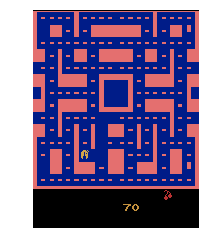

In [11]:
# load the weights from file
#torch.load(agent.qnetwork_local.state_dict(), model_dir+model_name)

for i in range(3):
    # watch an untrained agent
    states_stack = deque([torch.zeros(input_shape) for z in range(states_stack_depth)], maxlen=states_stack_depth)

    state = env.reset()
    state_inputs = state2StackedInputs(state, states_stack)
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(1000):
        action = agent.act(state_inputs)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()